In [1]:
from pytfa.io.json import load_json_model
from skimpy.io.yaml import  load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.core.parameters import ParameterValues
from skimpy.utils.namespace import *
from skimpy.core.modifiers import *
from skimpy.io.yaml import load_yaml_model
from skimpy.core.reactor import Reactor
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.viz.plotting import timetrace_plot
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
from skimpy.core.parameters import load_parameter_population
from skimpy.simulations.reactor import make_batch_reactor
from skimpy.core.solution import ODESolutionPopulation
from skimpy.utils.namespace import *
from skimpy.viz.escher import animate_fluxes, plot_fluxes
import copy
from skimpy.io.yaml import export_to_yaml
from skimpy.analysis.ode.utils import make_flux_fun

import pandas as pd
import numpy as np

import skimpy
import time
import matplotlib.pyplot as plt
import itertools
import matplotlib
import sys
sys.path.insert(1, 'functions/')


# benchmark functions
import simulation_functions as sf
import scenarios as sc



#ML methods
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import  AdaBoostRegressor

from scipy.stats import linregress

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [2]:
# functions
def scenario_simulation(designs,kmodel,sol_wt,parameter_values,cart):
    """Simulate a scenario based on the design list
    Input: Vmax Design List, Cartesian Design List,kmodel
    
    #cart, the design list for the index of vmax 
    
    Output: 
    - Relative Flux Change w.r.t Wildtype
    - Relative Metabolite Change w.r.t Wildtype
    - Design list for training"""
    #the perturbation integration
    met_plots="glx_c" #this I should remove from the function, no longer used
    rel_list=[]
    rel_flux_list=[]
    vmax_list=[]
    for i in designs:
        pmodel=sf.perturb_kmodel(kmodel,i,parameter_values)
        sol=sf.ode_integration(pmodel,met_plots,plotting=False)
        #vmax dictionary
        perturbed_values = {p.symbol:p.value for p in pmodel.parameters.values()}
        vmax=sf.vmax_finder(perturbed_values)
        vmax_index=list(vmax.keys())
        vmax=list(vmax.values())
        vmax_list.append(vmax)

        if sol.ode_solution.message=='Successful function return.':

            rel_change=sf.relative_met_change(sol_wt,sol)
            rel_list.append(rel_change)

            pmodel_parameters = {p.symbol:p.value for p in kmodel.parameters.values()}
            pmodel_parameters = ParameterValues(parameter_values, pmodel)
            for j,concentrations in sol.concentrations.iterrows():  
                flux_mt=flux_fun(concentrations,parameters=pmodel_parameters)
            rel_flux=sf.relative_flux_change(flux_wt,flux_mt)
            rel_flux_list.append(rel_flux)
        else:
            my_list=np.zeros(49)
            my_flux_list=np.zeros(65)
            my_list[:]=np.NaN
            my_flux_list[:]=np.NaN
            rel_list.append(my_list)
            rel_flux_list.append(my_flux_list)
    

    # Change in metabolite
    rel_change=pd.DataFrame(np.array(rel_list))
    rel_change.columns=sol_wt.names
    rel_change.index=cart

    #Change in flux
    rel_flux_change=pd.DataFrame(np.array(rel_flux_list))
    rel_flux_change.index=cart
    rel_flux_change.columns=list(flux_wt.keys())

    vmax=pd.DataFrame(np.array(vmax_list))
    vmax.columns=vmax_index
    vmax.index=cart
    vmax['Enzyme_G']=rel_flux_change['Enzyme_G']
    
    training_set=pd.DataFrame(np.array(list(vmax.index)),columns=enz_names)
    training_set['Enzyme_G']=list(vmax['Enzyme_G'])
    return rel_change, rel_flux_change, vmax,training_set


def test_set1_Xy(cart,cart_scenario,enz_names,test_set_size):
    """testing on a set of unseen examples
    - cart: set of designs from the full combinatorial space
    - cart_scenario: trainingset
    - N: size of the test_set"""
    test_cart=[]
    test_set_design=[]
    for i in cart:
        for j in cart_scenario:
            if i!=j:
                test_cart.append(i)
    index_set=np.arange(0,len(test_cart),1)
    random_choice=np.random.choice(index_set,test_set_size,replace=False)
    
    test_cart=[test_cart[i] for i in random_choice]
    cart_ind=test_cart
    #make a designlist from test
    for i in test_cart:
        temp=dict(zip(enz_names,i))
        test_set_design.append(temp)
    #make it a dataframe for prediction
    test_cart=pd.DataFrame(test_cart,columns=enz_names)
    return test_cart,test_set_design,cart_ind

def ML_methods(training_set,test_set):
    "wrapper s.t. we can call it iteratively for each scenario"
    #train test split
    X=['vmax_forward_Enzyme_A','vmax_forward_Enzyme_B',"vmax_forward_Enzyme_C",
       "vmax_forward_Enzyme_D","vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"]
    train_x=training_set[X]
    train_y=training_set['Enzyme_G']
    test_x=test_set_simulation[X]
    test_y=test_set_simulation['Enzyme_G']
    
    #svr
    regr_svr = svm.SVR()
    regr_svr.fit(train_x, train_y)
    prediction_svr=regr_svr.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,prediction_svr)
    score_svr=r_value**2
    
    #score_svr=regr_svr.score(test_x,test_y)
    #print("Support Vector Regressor: "+str(regr_svr.score(test_x,test_y)))
    #sgd
    regr_sgd = make_pipeline(StandardScaler(),SGDRegressor(loss="squared_error",max_iter=1000, tol=1e-3))
    regr_sgd.fit(train_x, train_y)
    predict_sgd=regr_sgd.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_sgd)
    score_sgd=r_value**2
    

    #print("Stochastic Gradient Descent Regressor: "+str(regr_sgd.score(test_x,test_y)))
    #rf
    regr_rf = RandomForestRegressor()
    regr_rf.fit(train_x, train_y)
    predict_rf=regr_rf.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
    score_rf=r_value**2

    #print("Random Forest: "+str(regr_rf.score(test_x,test_y)))
    #Elastic Net
    regr_elasticnet=ElasticNet()
    regr_elasticnet.fit(train_x,train_y)
    predict_elasticnet=regr_elasticnet.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_elasticnet)
    score_elasticnet=r_value**2
    
    #print("Elastic Net: "+str(regr_elasticnet.score(test_x,test_y)))
    #KNN
    regr_knn=KNeighborsRegressor(n_neighbors=5,weights="distance")
    regr_knn.fit(train_x,train_y)
    predict_knn=regr_knn.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_knn)
    score_knn=r_value**2
    
    #print("k Nearest Neighbors: "+str(regr_knn.score(test_x,test_y)))
    #GPR
    regr_GPR=GaussianProcessRegressor()
    regr_GPR.fit(train_x,train_y)
    predict_GPR=regr_GPR.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_GPR)
    score_GPR=r_value**2
    
    #print("Gaussian Process Regressor: "+str(regr_GPR.score(test_x,test_y))) 
    #this is probably an algorithm that needs to be finetuned more
    #Gradient boosting Regressor
    regr_GradBoostReg=GradientBoostingRegressor()
    regr_GradBoostReg.fit(train_x,train_y)
    predict_GradBoostReg=regr_GradBoostReg.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_GradBoostReg)
    score_GradBoost=r_value**2
    
    #print("Gradient Boosting Regressor: "+str(regr_GradBoostReg.score(test_x,test_y))) 
    # Neural Network
    regr_NN=MLPRegressor(max_iter=8000,activation="relu", learning_rate="adaptive")
    regr_NN.fit(train_x,train_y)
    predict_NN=regr_NN.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_NN)
    score_NN=r_value**2
    
    #print("Neural Network: "+str(regr_NN.score(test_x,test_y))) 
    algorithms=["SVR","SGD","RF","EN","kNN","GPR","GBR","NN"]
    scores=[score_svr,score_sgd,score_rf,score_elasticnet,score_knn,score_GPR,score_GradBoost,score_NN]
    scores=dict(zip(algorithms,scores))
    return scores 



In [10]:


filenames={
    "kmodel":"models/shiki_pathway_testmodel.yml",
    "tmodel":"models/shiki_pathway_testmodel_thermodynamic.json",
    "ref_solution":"data/sample06092022.csv",
    "batch_file":"models/single_species.yaml",
    "batch_kmodel":"models/kin_varma.yml"}

#load kinetic model and get parameter values
kmodel,ref_concentrations,tmodel=sf.setup_ode_system(filenames['kmodel'],filenames['tmodel'],filenames['ref_solution'])
parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
parameter_values = ParameterValues(parameter_values, kmodel)

#function in the skimpy package for retrieving the fluxes
flux_fun = make_flux_fun(kmodel, QSSA)


met_plots="glx_c"
#kinetic model wildtype ode integration
sol_wt=sf.ode_integration(kmodel,met_plots,plotting=False)
for i,concentrations in sol_wt.concentrations.iterrows():
            flux_wt=flux_fun(concentrations,parameters=parameter_values)


#enzymes to perturb ,'vmax_forward_PFK'
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]


#perturb_range=[1,1.1,1.2]
#for the kinetic model
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range) 
rel_list=[]
rel_flux_list=[]
vmax_list=[]


#test_met,test_flux,test_vmax,test_set_simulation=scenario_simulation(test_set_designs,kmodel,sol_wt,parameter_values,cart_test)
comb_met,comb_flux,comb_vmax, comb_cart=scenario_simulation(designs,kmodel,sol_wt,parameter_values,cart)

#this has a bug

pd.DataFrame(comb_met).to_csv("results/combinatorial_space/comb_met.csv")
pd.DataFrame(comb_flux).to_csv("results/combinatorial_space/comb_flux.csv")
pd.DataFrame(comb_vmax).to_csv("results/combinatorial_space/comb_cart.csv")


2022-10-12 15:31:42,495 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_17_462'] change to integer for linear dependencies
2022-10-12 15:31:43,017 - thermomodel_redGEMv1_MergedLMPDsAndBiomass - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2022-10-12 15:31:43,494 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_17_462'] change to integer for linear dependencies


In [7]:
comb_flux

,ACALD,ACALDtpp,ACONTa,ACONTb,ACS,ACt2rpp,AKGDH,AKGt2rpp,ALCD2x,ATPM,...,RPE,RPI,SUCCt3pp,SUCDi,SUCOAS,TALA,THD2pp,TKT1,TKT2,TPI
"(0.25, 0.25)",1.012513,1.008101,1.004062,1.004062,1.006686,1.006686,1.009768,1.002293,1.002635,0.999994,...,1.004795,1.001796,1.017889,1.003617,1.010202,0.991318,1.003211,1.000490,1.009741,1.000558
"(0.25, 0.5)",1.012513,1.008101,1.004062,1.004062,1.006686,1.006686,1.009768,1.002293,1.002635,0.999994,...,1.004795,1.001796,1.017889,1.003617,1.010202,0.991318,1.003211,1.000490,1.009741,1.000558
"(0.25, 1.0)",1.012513,1.008101,1.004062,1.004062,1.006686,1.006686,1.009768,1.002293,1.002635,0.999994,...,1.004795,1.001796,1.017889,1.003617,1.010202,0.991318,1.003211,1.000490,1.009741,1.000558
"(0.25, 1.5)",1.012513,1.008101,1.004062,1.004062,1.006686,1.006686,1.009768,1.002293,1.002635,0.999994,...,1.004795,1.001796,1.017889,1.003617,1.010202,0.991318,1.003211,1.000490,1.009741,1.000558
"(0.25, 2.0)",1.012513,1.008101,1.004062,1.004062,1.006686,1.006686,1.009768,1.002293,1.002635,0.999994,...,1.004795,1.001796,1.017889,1.003617,1.010202,0.991318,1.003211,1.000490,1.009741,1.000558
"(0.25, 4.0)",1.012513,1.008101,1.004062,1.004062,1.006686,1.006686,1.009768,1.002293,1.002635,0.999994,...,1.004795,1.001796,1.017889,1.003617,1.010202,0.991318,1.003211,1.000490,1.009741,1.000558
"(0.5, 0.25)",1.008516,1.005444,1.002697,1.002697,1.004484,1.004484,1.006438,1.001572,1.001696,0.999996,...,1.003250,1.001245,1.010867,1.002391,1.006713,0.994274,1.002185,1.000380,1.006547,1.000361
"(0.5, 0.5)",1.008516,1.005444,1.002697,1.002697,1.004484,1.004484,1.006438,1.001572,1.001696,0.999996,...,1.003250,1.001245,1.010867,1.002391,1.006713,0.994274,1.002185,1.000380,1.006547,1.000361
"(0.5, 1.0)",1.008516,1.005444,1.002697,1.002697,1.004484,1.004484,1.006438,1.001572,1.001696,0.999996,...,1.003250,1.001245,1.010867,1.002391,1.006713,0.994274,1.002185,1.000380,1.006547,1.000361
"(0.5, 1.5)",1.008516,1.005444,1.002697,1.002697,1.004484,1.004484,1.006438,1.001572,1.001696,0.999996,...,1.003250,1.001245,1.010867,1.002391,1.006713,0.994274,1.002185,1.000380,1.006547,1.000361


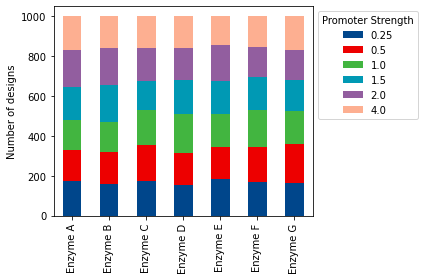

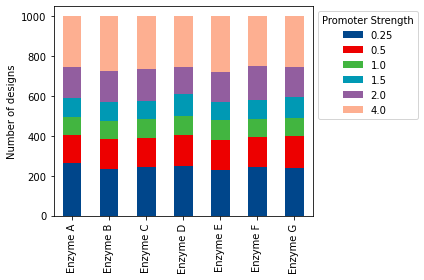

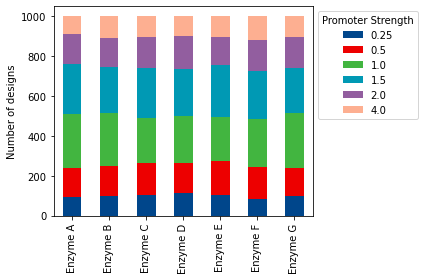

In [14]:
N_designs=1000

N_iterations=3

#enzymes to perturb ,'vmax_forward_PFK'
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]



#perturb_range=[1,1.1,1.2]
#for the kinetic model
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range) 



sc1_designs,sc1_cart=sc.scenario1(perturb_range,N_designs,enz_names)
sc2_designs,sc2_cart=sc.scenario2(perturb_range,N_designs,enz_names)
sc3_designs,sc3_cart=sc.scenario3(perturb_range,N_designs,enz_names)
plot_sc1=sc.plot_promoter_distribution(enz_names,sc1_cart)
plot_sc2=sc.plot_promoter_distribution(enz_names,sc2_cart)
plot_sc3=sc.plot_promoter_distribution(enz_names,sc3_cart)
plot_sc1=plot_sc1.get_figure()
plot_sc2=plot_sc2.get_figure()
plot_sc3=plot_sc3.get_figure()
plot_sc1.tight_layout()
plot_sc2.tight_layout()
plot_sc3.tight_layout()

plot_sc1.savefig("results/plots/svg/plot_sc1"+run_name+".svg")
plot_sc2.savefig("results/plots/svg/plot_sc2"+run_name+".svg")
plot_sc3.savefig("results/plots/svg/plot_sc3"+run_name+".svg")

plot_sc1.savefig("results/plots/png/plot_sc1"+run_name+".png")
plot_sc2.savefig("results/plots/png/plot_sc2"+run_name+".png")
plot_sc3.savefig("results/plots/png/plot_sc3"+run_name+".png")